# 🍔 Multivariate Testing - Fast Food Marketing

## 0. Overview

In this notebook we are conducting statistical analysis and A/B Multivariate testing for a Fast Food Marketing Campaign. There is a new fast food item being introduced and there are 3 possible marketing campaigns. 

Dataset taken from [Kaggle](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test)

**🎯 Objective:**

Compare sales amounts between 3 different promotion tactics. Which promotion has the greatest effect on sales? 

### 0.1 Hypotheses and Metrics

* **H₀** (null hypothesis) - the 3 promotion tactics have the same effectivity for sales of the new item.
* **Hₐ** (alternative hypothesis) - there is a significant difference  in the effectivity of the 3 promotions. 

* Target metric - Sales amount *(SalesInThousands)*

*Note: There is no control or experiment group given that all 3 groups are being introduced*

### 0.2 Importing

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chisquare

%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context(
    "notebook",
    rc={"axes.titlesize": 14, "axes.titleweight": "bold", "axes.labelsize": 11})
trio_palette = ['red', 'orange', 'yellow']

Loading dataset

In [48]:
file_path = "dataset/WA_Marketing-Campaign.csv"
df_import = pd.read_csv(file_path, header=0)
df = df_import.copy()

### 0.3 Dataset Overview

#### Feature Info

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


**Features:**
* **MarketID**: unique identifier for market
* **MarketSize**: size of market area by sales
* **LocationID**: unique identifier for store location
* **AgeOfStore**: age of store in years
* **Promotion**: one of three promotions that were tested
* **week**: one of four weeks when the promotions were run
* **SalesInThousands**: sales amount for a specific LocationID, Promotion, and week

#### Dataframe Preview

In [50]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## 🧹 1. Data Cleaning

#### 1.1 Check for null or duplicate values

In [51]:
print("Null values in the df: ", df.isnull().sum().sum())
print("Duplicate values in the df: ", df.duplicated().sum())

Null values in the df:  0
Duplicate values in the df:  0


There are no null or duplicate values detected

#### 1.2 Check for anomalies in discrete features
Are there unique values besides the supposed discrete options?

In [52]:
for col in df.columns:
    unique_vals = df[col].unique()
    display_vals = unique_vals[:10]
    suffix = "..." if len(unique_vals) > 10 else ""
    print(f"{col}: {display_vals}{suffix}\n")

MarketID: [ 1  2  3  4  5  6  7  8  9 10]

MarketSize: ['Medium' 'Small' 'Large']

LocationID: [ 1  2  3  4  5  6  7  8  9 10]...

AgeOfStore: [ 4  5 12  1 10 15  6 22  8 19]...

Promotion: [3 2 1]

week: [1 2 3 4]

SalesInThousands: [33.73 35.67 29.03 39.25 27.81 34.67 27.98 27.72 44.54 37.94]...



There are no anomalies in discrete data values

### 1.3 Treating Outliers

Text(0.5, 1.0, 'Age Distribution')

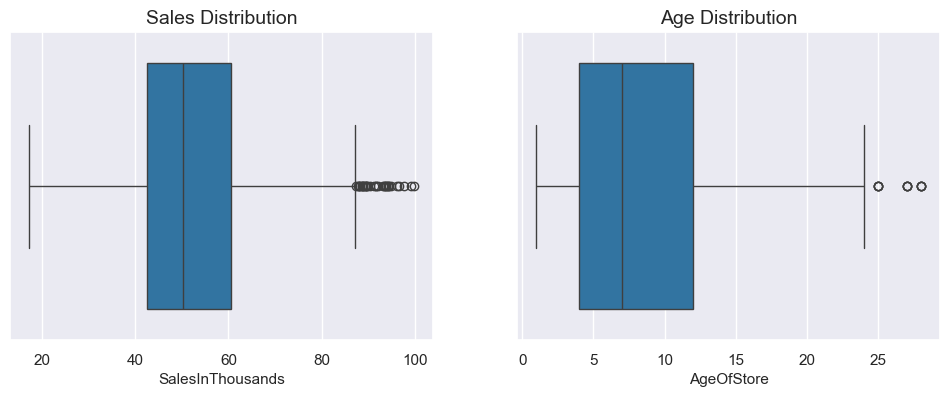

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(df, x='SalesInThousands', ax=axes[0])
axes[0].set_title('Sales Distribution')

sns.boxplot(df, x='AgeOfStore', ax=axes[1])
axes[1].set_title('Age Distribution')

- In both features of Age and Sales, outliers are of the higher regard
    - Outliers in age are older stores
    - Outliers in sales are higher earning stores

In [54]:
# Select only the continuous variables for outlier detection
num_cols = df[["AgeOfStore", "SalesInThousands"]]

# Calculate Q1, Q3, and IQR
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (num_cols < lower_bound) | (num_cols > upper_bound)

outlier_values = num_cols[outliers].stack().reset_index()
outlier_values.columns = ["idx", "features", "value"]

outlier_grouped = outlier_values.groupby("idx").agg({
    "features": list,
    "value": list
}).reset_index()
outlier_grouped = outlier_grouped.sort_values(by='value', ascending=False)
print(outlier_grouped.head())


    idx            features    value
26  144  [SalesInThousands]  [99.65]
30  154  [SalesInThousands]  [99.12]
15  111  [SalesInThousands]  [97.61]
10  104  [SalesInThousands]  [96.48]
13  109  [SalesInThousands]  [96.01]


In [55]:
print("Outlier value count: ", len(outlier_values))
percent_outliers = (len(outlier_values) / len(df)) * 100
print(f"Percent of outliers: {percent_outliers:.2f}%")

Outlier value count:  45
Percent of outliers: 8.21%


- 45 Outliers contribute to ~8% of the data
- We will keep these outliers as they simply represent higher earning stores and older stores, but are not concerning anomalies

## 2. Analysis

**Visual Guide** \
In the theme of fast food and appetite, this notebook will be using a Red, Orange, and Yellow (ROY) per Promotion, a color palette known to be related to food and appetite.
* 🟥 Promotion 1 - Red 
* 🟧 Promotion 2 - Orange 
* 🟨 Promotion 3 - Yellow 

### 2.1 Sample Ratio Mismatch (SRM) Check

In [56]:
counts = df["Promotion"].value_counts().sort_index()
counts

Promotion
1    172
2    188
3    188
Name: count, dtype: int64

In [57]:
labels = [f'Promotion {i}' for i in counts.index]

fig = go.Figure(go.Pie(labels=labels, 
                       values=counts, 
                       marker=dict(colors=trio_palette),
                       textinfo='label+percent'))
fig.update_layout(title='Proportions between Promotions')
fig.show()

#### Chi-square goodness-of-fit Testing for SRM

Compares observed vs. expected counts - expected being an equal amount between two groups

We must mathematically check for Sample Ratio Mismatch (SRM) between the two groups.

To do so, for this section, we will be observing another pair of hypotheses:
* **H₀** : The two groups are balanced. There is no sample ratio mismatch detected.
* **Hₐ** : The two groups are not balanced. There is a significant mismatch.

We will be using a stricter significance threshhold (α) that is more commonplace for SRM (SRM is a sensitive value): 
* **α = 0.01**

In [58]:
observed = counts.values

expected = [observed.sum() / len(observed)] * len(observed)

Expected counts being an even split between the data

In [59]:
chi, p_value = chisquare(f_obs=observed, f_exp=expected)
print("Chi-squared statistic:", chi)
print("p-value:", p_value)

if p_value <= 0.01:
    print("Conclusion: Warning - SRM may be present.")
else:
    print("Conclusion: SRM not likely.")

Chi-squared statistic: 0.9343065693430658
p-value: 0.6267840066678985
Conclusion: SRM not likely.


**p 0.62 > α 0.01**

The p-value 0.62 is much greater than α 0.01, so it is not below our significance threshold.
* This gives us high confidence that:
    * SRM is extremely unlikely
    * The AB test **passes the SRM check through chi-squared testing**

### 2.2 Distribution

To help make decisions on our route of A/B testing, the distribution of the data must be observed

In [ ]:
mean = df["SalesInThousands"].mean()
median = df["SalesInThousands"].median()
mode = df["SalesInThousands"].mode()[0]

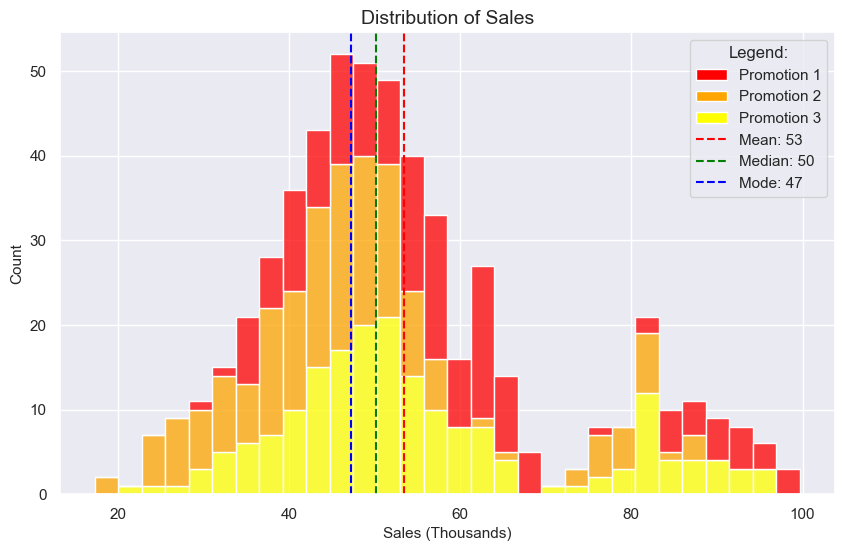

In [66]:
plt.figure(figsize=(10, 6))

sns.histplot(
    df,
    x="SalesInThousands",
    hue="Promotion",
    multiple="stack",
    stat="count",
    bins=30,
    palette=trio_palette
)

mean_line = plt.axvline(mean, color="red", linestyle="--")
median_line = plt.axvline(median, color="green", linestyle="--")
mode_line = plt.axvline(mode, color="blue", linestyle="--")

label_icons = [
    Patch(facecolor=trio_palette[0]),
    Patch(facecolor=trio_palette[1]),
    Patch(facecolor=trio_palette[2]),
    Line2D([0], [0], color="red", linestyle="--"),
    Line2D([0], [0], color="green", linestyle="--"),
    Line2D([0], [0], color="blue", linestyle="--"),
]

custom_labels = [
    "Promotion 1",
    "Promotion 2",
    "Promotion 3",
    f"Mean: {mean:.0f}",
    f"Median: {median:.0f}",
    f"Mode: {mode:.0f}",
]
plt.legend(handles=label_icons, labels=custom_labels, title="Legend:")

plt.title("Distribution of Sales")
plt.xlabel("Sales (Thousands)");

**Mean, Median, Mode:**
* Mean: The average number of rounds is 47. 
* Median: Middle point of the distribution 18. 50% of players play fewer than 18 rounds, 50% play more than 18.
* Mode: The largest amount of players leave after 1 gameround, characteristic of mobile games where players try out an app.

**Distribution: Normal**

**Promotion:**

It is visually noticeable that **Promotion 1** has higher sales than the other 2 campaigns.

## 3. Statistical Testing

### 3.1 _____ Testing

* Control group - gate 30
* Experimental group - gate 40
* Metric - Player retention over 1 week
* **α = 0.05**

### 3.2 Bootstrapping

### 3.3 95% Confidence Intervals

In [ ]:
from statsmodels.stats.proportion import proportion_confint

ci = contingency_table.apply(
    lambda row: proportion_confint(
        count=row[True], nobs=row.sum(), alpha=0.05, method="wilson"
    ),
    axis=1,
)

retention_rates["ci_lower (%)"] = [x[0] * 100 for x in ci]
retention_rates["ci_upper (%)"] = [x[1] * 100 for x in ci]

retention_rates

retention_7,False,True,ci_lower (%),ci_upper (%)
version,,,,
gate_30,80.157617,19.842383,19.467103,20.223082
gate_40,80.967950,19.032050,18.665611,19.403966


The 95% Confidence Intervals are relatively **narrow**, with **upper and lower bounds no farther than 1% off** the rate, indicating confidence in a precise estimation and a small amount of uncertainty around the retention rate. 

### 3.3 📊 Visualization of A/B Test

From the calculations above - Retention Rates, p-value, and confidence intervals - we can visualize our final results

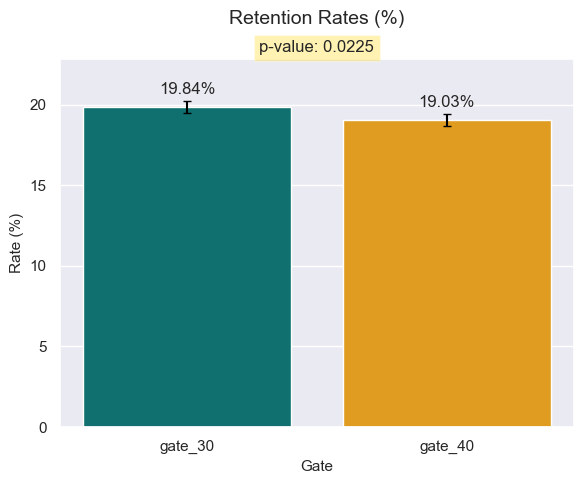

In [ ]:
plot_df = retention_rates[True].reset_index()
plot_df.columns = ["Gate", "Retention_7"]

plt.figure(figsize=(6, 5))
ax = sns.barplot(
    plot_df, x="Gate", y="Retention_7", hue="Gate", palette=["teal", "orange"]
)

yerr = np.array(
    [
        plot_df["Retention_7"] - retention_rates["ci_lower (%)"].values,
        retention_rates["ci_upper (%)"].values - plot_df["Retention_7"],
    ])

plt.errorbar(
    x=np.arange(len(plot_df)),
    y=plot_df["Retention_7"],
    yerr=yerr,
    fmt="none",
    ecolor="black",
    capsize=3,
)

for i, rate in enumerate(plot_df["Retention_7"]):
    plt.text(i, rate + 0.8, f"{rate:.2f}%", ha="center")

plt.title("Retention Rates (%)", pad=25)

plt.text(
    0.5, 1.01,
    s=f"p-value: {p_value:.4f}",
    ha="center",
    va="bottom",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="gold", alpha=0.3),
)

plt.ylabel("Rate (%)")
plt.ylim(0, max(plot_df["Retention_7"]) + 3)
plt.tight_layout()

The actual percentage difference in retention rates is small (~0.8% difference), but chi-square test uncovers and confirms that it is statistically significant enough to state that Gate 30 has a higher retention rate.

## 4. Conclusion
**Data**:
* Distribution of data is exponential and skewed
* Target metric is discrete (True/False) for Retention over 7 days
* The above leads us to choosing the chi-squared test of independence, with the following results:
    * p-value of 0.02 is below our threshold of 0.05


**Retention Rates** and our **A/B testing results**:
* We reject our null hypothesis that the gates have the same player retention. 
* Gate 30 has a statistically significant higher rate of retention
    * Conclusive that players gravitate to the earlier checkpoint as a faster incentive
    * The Cookie Cats team should keep the first gate in the game as Gate 30 

Goal. Based on the dataset description in Kaggle, describe the goal of the A/B test. Give any necessary context.
Target metric. Choose a target metric and describe how it measures progress towards the stated goal of the A/B test.
Calculations.

Some tips:

There are several statistical tests that you might need during this project - Student’s t-test, binomial test and the chi-square test. Here are some good resources on them:
Student’s t-test and Scipy documentation
Chi-square test and Scipy documentation
For statistical tests, feel free to check your numbers against those given by the Evan Miller A/B Test Calculator.
You will notice that the number of samples in each variant is not the same. Some discrepancy should be expected due to randomness, but large differences, when they are not expected, are a symptom of a bug in the way units were randomized. This is known as sample ratio mismatch (SRM). Before proceeding with the analysis of the test, test for sample ratio mismatch using the chi-square test.

- In your notebook, aggregate and prepare data as needed. Report key information about the A/B test, including the sample size and variant proportions.
- Conduct statistical tests. Describe which test you have chosen for each metric and why.
- Report the estimated treatment effect, confidence interval and p-value. For one of the datasets, compute the confidence interval both analytically and using bootstrap and report both intervals.
- Decision. Describe clearly what your calculations imply and which decision you recommend. Use visualizations to show differences in the metric between groups and confidence intervals.


In addition to the notebooks, create a dashboard with at least two plots. One of the plots should illustrate how the target metric changes across the weeks in the Fast Food Marketing Campaign A/B test.
